# Usage (quick version)
This is a quick tour of CovsirPhy. Details of datasets and scenario analysis will be explained.

## Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.12.0-pi.new.339.357.359.362.366.367.383.fix.360.373'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

### Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [5]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot.

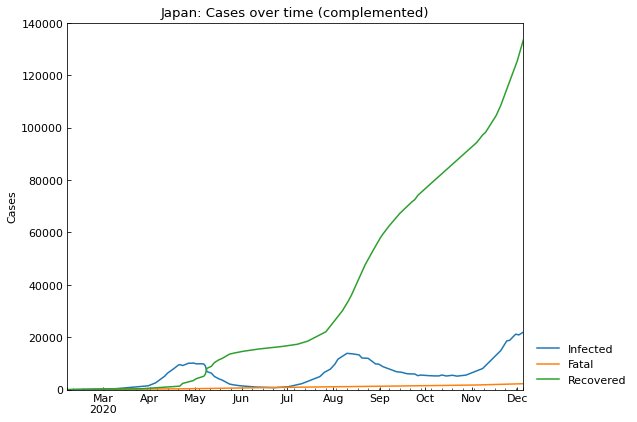

,Date,Confirmed,Infected,Fatal,Recovered
299,2020-12-01,148694,21085,2139,125470
300,2020-12-02,150386,20910,2172,127304
301,2020-12-03,152827,21373,2213,129241
302,2020-12-04,155232,21816,2240,131176
303,2020-12-05,157674,21948,2283,133443


In [6]:
record_df = snl.records()
record_df.tail()

We can calculate the number of new cases with `Scenario.record_diff()` method.

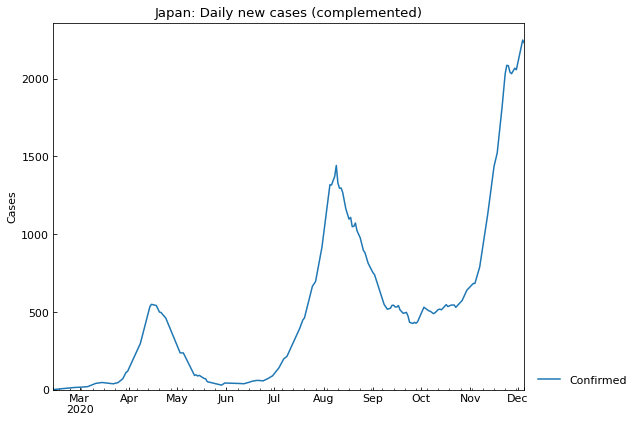

In [9]:
_ = snl.records_diff(variables=["Confirmed"], window=7)

### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

In [ ]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [ ]:
# Estimate the parameter values of SIR-F model
snl.estimate(cs.SIRF)

In [ ]:
# Show the sumamry of parameter estimation
snl.summary()

### Accuracy of estimation

In [ ]:
snl.estimate_accuracy(phase="1st")

### Get parameter value

In [ ]:
snl.get("Rt", phase="4th")

### Show parameter history

In [ ]:
_ = snl.history(target="rho")

In [ ]:
_ = snl.history(target="sigma")

### Show the history of reproduction number

In [ ]:
_ = snl.history(target="Rt")

### Simulate the number of cases

In [ ]:
snl.clear(name="Main")
snl.add(days=30)
snl.add(end_date="01Apr2021", name="Main")
main_sim_df = snl.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [ ]:
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

In [ ]:
sigma_new = sigma_current * 2
sigma_new

In [ ]:
snl.clear(name="Medicine")
snl.add(name="Medicine", days=30, sigma=sigma_current)
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary()

In [ ]:
snl.simulate(name="Medicine").tail()

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values.

In [ ]:
snl.describe()

In [ ]:
_ = snl.history(target="Rt")

In [ ]:
_ = snl.history(target="rho")

In [ ]:
_ = snl.history(target="sigma")

In [ ]:
_ = snl.history(target="Infected")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

In [ ]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [ ]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")

In [ ]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

In [ ]:
# History of reproduction number
_ = snl_retro.history("Rt")

In [ ]:
# History of Infected
_ = snl_retro.history("Infected")

In [ ]:
# Show the representative values
snl_retro.describe()